### ***                 CHỦ ĐỀ:  ỨNG DỤNG MÔ HÌNH HỌC MÁY VÀO DỰ ĐOÁN SỐ ĐIỆN SỬ DỤNG TRONG THÁNG***


# Cách sử dụng trên Google Colab:

---




**Bước 1: Cài đặt kagglehub (chạy cell đầu tiên)**

**Bước 2: Xác thực Kaggle (Ở đây dataset ta chọn electric-power-consumption-data-set là public nên không cần xác thực)**

**Bước 3: Chạy các cell theo thứ tự**


---




In [147]:
#Cài đặt và import các thư viện cần thiết
!pip install kagglehub[pandas-datasets]
!pip install optuna
!pip install holidays
import optuna
from sklearn.linear_model import Ridge, Lasso, LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import warnings
import holidays
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# **1. TIỀN XỬ LÝ DỮ LIỆU (PREPROCESSING)**

---


*1.1. Tải và Làm sạch dữ liệu*

---



In [148]:
# 1.1 Tải dữ liệu
print("\n[1.1] Đang tải dữ liệu từ Kaggle...")
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")
df = pd.read_csv(f"{path}/household_power_consumption.txt", sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 low_memory=False, na_values=['?'])
df.set_index('datetime', inplace=True)
print(f"✓ Đã tải {len(df)} dòng dữ liệu từ {df.index.min()} đến {df.index.max()}")


[1.1] Đang tải dữ liệu từ Kaggle...
Using Colab cache for faster access to the 'electric-power-consumption-data-set' dataset.
✓ Đã tải 2075259 dòng dữ liệu từ 2006-12-16 17:24:00 đến 2010-11-26 21:02:00




---

1.2 Gom nhóm theo ngày

---



In [149]:
print("\n[1.2] Gom nhóm dữ liệu theo ngày...")
df_daily = df['Global_active_power'].resample('D').sum().to_frame()
print(f"✓ Đã gom thành {len(df_daily)} ngày")


[1.2] Gom nhóm dữ liệu theo ngày...
✓ Đã gom thành 1442 ngày




---
1.3 Xử lý dữ liệu thiếu

---




In [150]:
print("\n[1.3] Xử lý dữ liệu thiếu...")
missing_before = df_daily['Global_active_power'].isna().sum()
df_daily['Global_active_power'] = df_daily['Global_active_power'].interpolate(method='time')
missing_after = df_daily['Global_active_power'].isna().sum()
print(f"✓ Giảm từ {missing_before} → {missing_after} giá trị thiếu")


[1.3] Xử lý dữ liệu thiếu...
✓ Giảm từ 0 → 0 giá trị thiếu




---
1.4 Xử lý giá trị ngoại lai

---




In [151]:
print("\n[1.4] Xử lý outliers...")
upper_limit = df_daily['Global_active_power'].quantile(0.99)
outliers_count = (df_daily['Global_active_power'] > upper_limit).sum()
df_daily['Global_active_power'] = df_daily['Global_active_power'].clip(upper=upper_limit)
print(f"✓ Đã xử lý {outliers_count} outliers (> {upper_limit:.2f} kWh)")


[1.4] Xử lý outliers...
✓ Đã xử lý 15 outliers (> 3315.78 kWh)




---
1.5 Tích hợp ngày lễ

---




In [152]:
print("\n[1.5] Tích hợp thông tin ngày lễ...")
fr_holidays = holidays.France()
df_daily['is_holiday'] = df_daily.index.map(lambda x: 1 if x in fr_holidays else 0).astype(int)
print(f"✓ Đã đánh dấu {df_daily['is_holiday'].sum()} ngày lễ")


[1.5] Tích hợp thông tin ngày lễ...
✓ Đã đánh dấu 42 ngày lễ




---
1.6 Tích hợp nhiệt độ

---




In [153]:
print("\n[1.6] Tích hợp nhiệt độ trung bình theo tháng...")
temp_map = {1: 5, 2: 6, 3: 10, 4: 15, 5: 19, 6: 23, 7: 25, 8: 24, 9: 20, 10: 15, 11: 9, 12: 6}
df_daily['temp_mean'] = df_daily.index.month.map(temp_map)
df_daily['temp_deviation'] = df_daily['temp_mean'] - 15
print(f"✓ Phạm vi nhiệt độ: {df_daily['temp_mean'].min()}°C - {df_daily['temp_mean'].max()}°C")


[1.6] Tích hợp nhiệt độ trung bình theo tháng...
✓ Phạm vi nhiệt độ: 5°C - 25°C


In [154]:
print(f"\n✓ HOÀN TẤT TIỀN XỬ LÝ")
print(f"Các cột: {df_daily.columns.tolist()}")
print(f"Kích thước: {df_daily.shape}")


✓ HOÀN TẤT TIỀN XỬ LÝ
Các cột: ['Global_active_power', 'is_holiday', 'temp_mean', 'temp_deviation']
Kích thước: (1442, 4)






---

**2. KHÁM PHÁ DỮ LIỆU TRỰC QUAN (EDA)**
---
2.1. Biểu đồ 1: Phân bổ

---




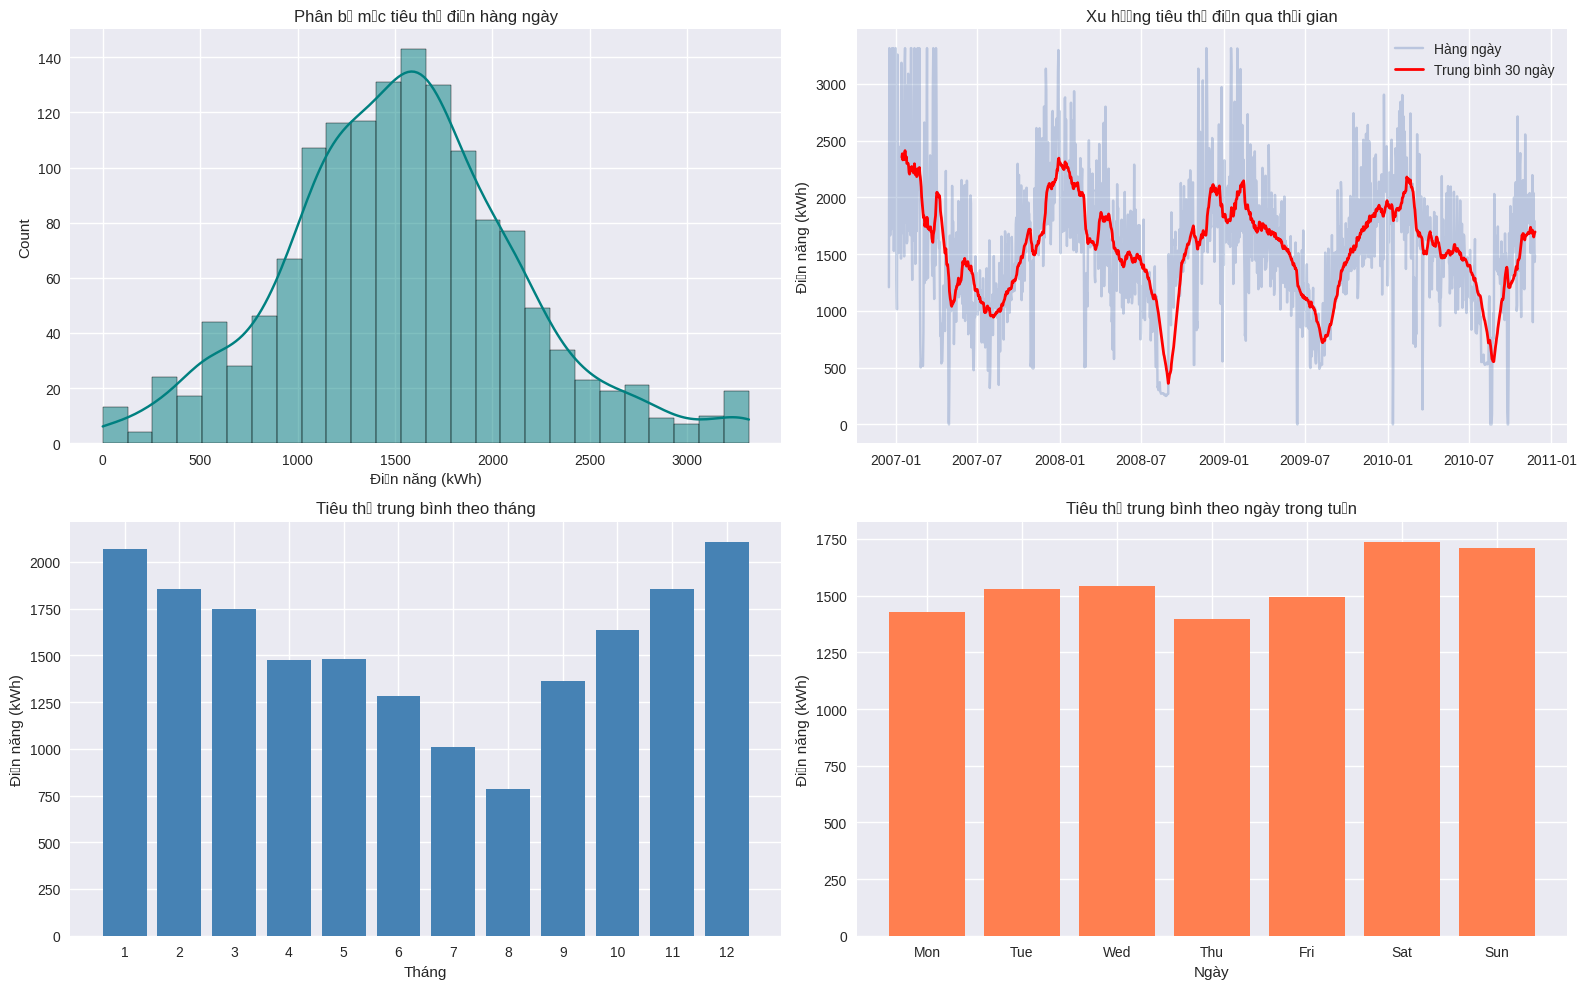

In [155]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Biểu đồ 1: Phân bổ
sns.histplot(df_daily['Global_active_power'], kde=True, ax=axes[0,0], color='teal')
axes[0,0].set_title('Phân bổ mức tiêu thụ điện hàng ngày')
axes[0,0].set_xlabel('Điện năng (kWh)')

# Biểu đồ 2: Xu hướng
axes[0,1].plot(df_daily['Global_active_power'], alpha=0.3, label='Hàng ngày')
axes[0,1].plot(df_daily['Global_active_power'].rolling(30).mean(),
               color='red', linewidth=2, label='Trung bình 30 ngày')
axes[0,1].set_title('Xu hướng tiêu thụ điện qua thời gian')
axes[0,1].legend()
axes[0,1].set_ylabel('Điện năng (kWh)')

# Biểu đồ 3: Theo tháng
monthly_avg = df_daily.groupby(df_daily.index.month)['Global_active_power'].mean()
axes[1,0].bar(monthly_avg.index, monthly_avg.values, color='steelblue')
axes[1,0].set_title('Tiêu thụ trung bình theo tháng')
axes[1,0].set_xlabel('Tháng')
axes[1,0].set_ylabel('Điện năng (kWh)')
axes[1,0].set_xticks(range(1, 13))

# Biểu đồ 4: Theo ngày trong tuần
weekly_avg = df_daily.groupby(df_daily.index.dayofweek)['Global_active_power'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,1].bar(range(7), weekly_avg.values, color='coral')
axes[1,1].set_title('Tiêu thụ trung bình theo ngày trong tuần')
axes[1,1].set_xlabel('Ngày')
axes[1,1].set_ylabel('Điện năng (kWh)')
axes[1,1].set_xticks(range(7))
axes[1,1].set_xticklabels(days)

plt.tight_layout()
plt.show()



---
## **3.FEATURE ENGINEERING (KỸ THUẬT ĐẶC TRƯNG)**

---

3.1 Tạo các đặc trwngg nâng cao

In [156]:
def create_advance_features(df):

    df = df.copy()

    # Đặc trưng thời gian cơ bản
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

    # Mã hóa chu kỳ (sin/cos) - FIX: Thêm day_sin/day_cos
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['day_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)

    # Đặc trưng lịch sử (Lags)
    df['lag_1'] = df['Global_active_power'].shift(1)
    df['lag_7'] = df['Global_active_power'].shift(7)

    # Đặc trưng cửa sổ trượt
    df['rolling_mean_7'] = df['Global_active_power'].rolling(window=7).mean().shift(1)
    df['rolling_std_7'] = df['Global_active_power'].rolling(window=7).std().shift(1)

    # Biến tương tác thông minh
    df['temp_impact'] = df['temp_mean'] * df['lag_1']
    df['energy_diff'] = df['lag_1'] - df['rolling_mean_7']

    return df.dropna()
print("\n[3.1] Tạo các đặc trưng...")
data = create_advance_features(df_daily)
print(f"✓ Đã tạo {len(data.columns)} cột đặc trưng")
print(f"  Kích thước sau khi dropna: {data.shape}")


[3.1] Tạo các đặc trưng...
✓ Đã tạo 17 cột đặc trưng
  Kích thước sau khi dropna: (1435, 17)




---
3.2 Ma trận tương quan

---





 Phân tích tương quan...


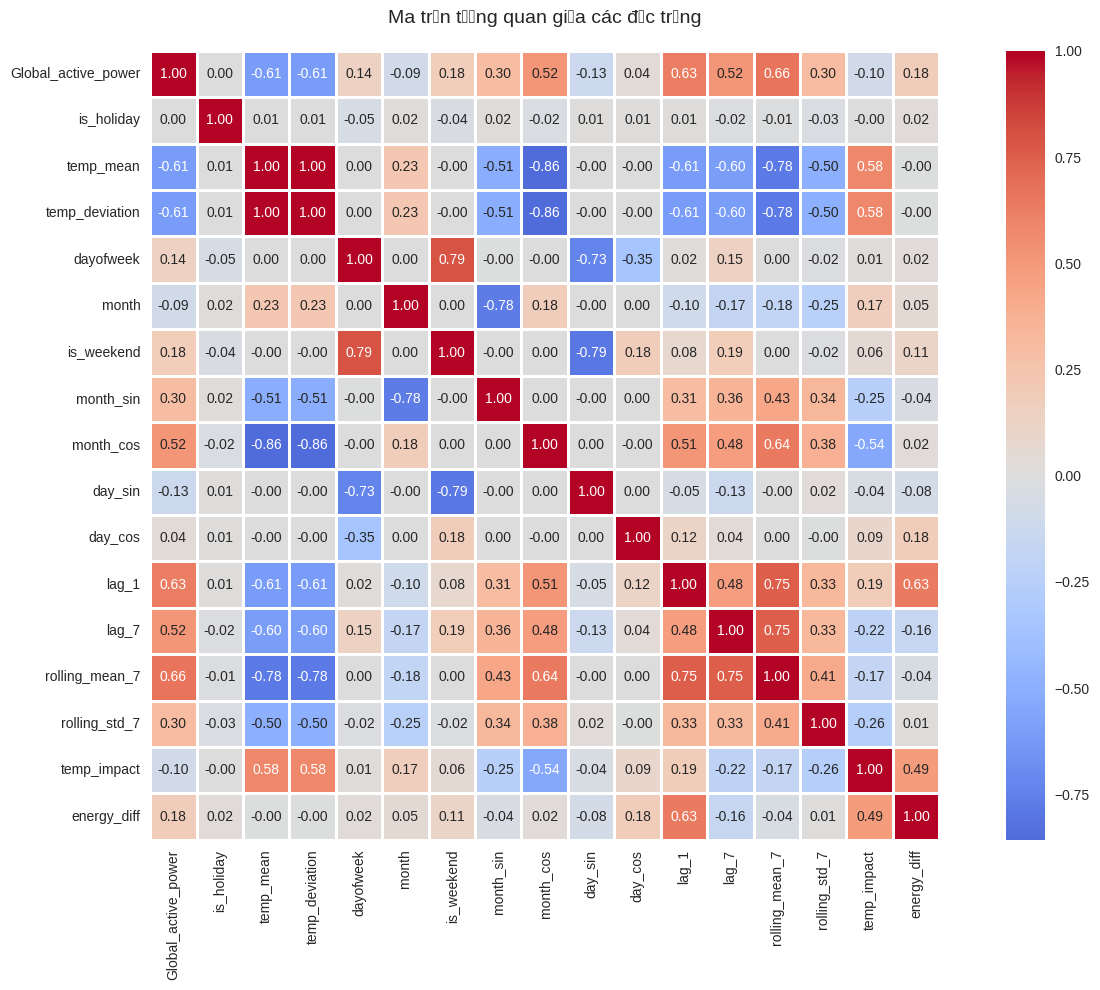

In [157]:
print("\n Phân tích tương quan...")
plt.figure(figsize=(14, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Ma trận tương quan giữa các đặc trưng', fontsize=14, pad=20)
plt.tight_layout()
plt.show()



---
3.3 Chuẩn hóa lại data dựa trên mức độ quan trọng

---




In [158]:
print("\n[3.3] Lọc đặc trưng quan trọng...")
target = 'Global_active_power'

# Loại bỏ các biến thừa thãi
features_to_drop = ['temp_deviation', 'month', 'dayofweek']

# Tính tương quan với target
correlations = data.corr()[target].abs().sort_values(ascending=False)
threshold = 0.05
numeric_features = correlations[correlations > threshold].index.tolist()

# Tổng hợp danh sách cuối
selected_features = [f for f in numeric_features
                    if f != target and f not in features_to_drop]

# Đảm bảo giữ các biến chu kỳ
cyclical_features = ['month_sin', 'month_cos', 'day_sin', 'day_cos']
for feat in cyclical_features:
    if feat not in selected_features and feat in data.columns:
        selected_features.append(feat)

print(f"✓ Số đặc trưng được chọn: {len(selected_features)}")
print(f"✓ Danh sách: {selected_features}")

# Chuẩn bị dữ liệu
X = data[selected_features]
y = data[target]

print(f"\n✓ HOÀN TẤT FEATURE ENGINEERING")
print(f"  Shape: X={X.shape}, y={y.shape}")


[3.3] Lọc đặc trưng quan trọng...
✓ Số đặc trưng được chọn: 12
✓ Danh sách: ['rolling_mean_7', 'lag_1', 'temp_mean', 'month_cos', 'lag_7', 'rolling_std_7', 'month_sin', 'is_weekend', 'energy_diff', 'day_sin', 'temp_impact', 'day_cos']

✓ HOÀN TẤT FEATURE ENGINEERING
  Shape: X=(1435, 12), y=(1435,)


## **4. CHIA DỮ LIỆU VÀ CHUẨN HÓA**


---




In [159]:
print("\n" + "="*80)
print("PHẦN 4: CHIA DỮ LIỆU VÀ CHUẨN HÓA")
print("="*80)

n = len(data)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

train_df = data.iloc[:train_end]
val_df = data.iloc[train_end:val_end]
test_df = data.iloc[val_end:]
train_val_df = data.iloc[:val_end]

print(f"\n✓ Chia dữ liệu:")
print(f"  Train:     {len(train_df)} mẫu ({train_df.index.min()} → {train_df.index.max()})")
print(f"  Validation: {len(val_df)} mẫu ({val_df.index.min()} → {val_df.index.max()})")
print(f"  Test:      {len(test_df)} mẫu ({test_df.index.min()} → {test_df.index.max()})")

# Chuẩn hóa
scaler = MinMaxScaler()
X_train = train_df[selected_features]
y_train = train_df[target]
X_train_scaled = scaler.fit_transform(X_train)

X_train_val_scaled = scaler.transform(train_val_df[selected_features])
y_train_val = train_val_df[target]

print(f"\n✓ Đã chuẩn hóa dữ liệu về khoảng [0, 1]")



PHẦN 4: CHIA DỮ LIỆU VÀ CHUẨN HÓA

✓ Chia dữ liệu:
  Train:     1004 mẫu (2006-12-23 00:00:00 → 2009-09-21 00:00:00)
  Validation: 215 mẫu (2009-09-22 00:00:00 → 2010-04-24 00:00:00)
  Test:      216 mẫu (2010-04-25 00:00:00 → 2010-11-26 00:00:00)

✓ Đã chuẩn hóa dữ liệu về khoảng [0, 1]




---
## **5. DỰ BÁO CUỐN CHIẾU (RECURSIVE FORECASTING)**

---



In [160]:
def recursive_forecast(model, scaler, history_df, selected_features, steps=30):

    current_history = history_df.copy()
    forecasts = []

    fr_holidays = holidays.France()
    temp_map = {1: 5, 2: 6, 3: 10, 4: 15, 5: 19, 6: 23, 7: 25,
                8: 24, 9: 20, 10: 15, 11: 9, 12: 6}

    for step in range(steps):
        # Tạo đặc trưng từ lịch sử
        features = create_advance_features(current_history)
        X_next = features[selected_features].iloc[-1:]

        # Dự báo
        X_next_scaled = scaler.transform(X_next)
        y_pred = max(0, model.predict(X_next_scaled)[0])
        forecasts.append(y_pred)

        # Cập nhật lịch sử cho vòng lặp tiếp theo
        next_date = current_history.index[-1] + pd.Timedelta(days=1)
        is_h = 1 if next_date in fr_holidays else 0
        t_mean = temp_map[next_date.month]
        t_dev = t_mean - 15

        new_row = pd.DataFrame({
            'Global_active_power': [y_pred],
            'is_holiday': [is_h],
            'temp_mean': [t_mean],
            'temp_deviation': [t_dev]
        }, index=[next_date])

        current_history = pd.concat([current_history, new_row])

    return np.array(forecasts)

## **6. THỰC NGHIỆM VÀ TỐI ƯU TỪNG MÔ HÌNH**

---

6.1. Hàm đánh giá mô hình trên Recursive Forecast

---



In [161]:
def get_recursive_metrics(model, scaler, df_daily, start_idx, steps=30, selected_features=None):

    history_df = df_daily.iloc[start_idx - 60 : start_idx].copy()
    actual_series = df_daily.iloc[start_idx : start_idx + steps]['Global_active_power']
    current_steps = len(actual_series)

    if current_steps == 0:
        return None

    preds = recursive_forecast(model, scaler, history_df, selected_features, steps=current_steps)
    actual = actual_series.values

    # Tính các chỉ số
    rmse = np.sqrt(mean_squared_error(actual, preds))
    mae = mean_absolute_error(actual, preds)
    mape = np.mean(np.abs((actual - preds) / (actual + 1e-10))) * 100
    r2 = r2_score(actual, preds)

    total_actual = actual.sum()
    total_pred = preds.sum()
    total_err_pct = abs(total_actual - total_pred) / (total_actual + 1e-10) * 100

    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Total_Err_Pct': total_err_pct,
        'Forecasts': preds,
        'Actual': actual_series,
        'Actual_Sum': total_actual,
        'Pred_Sum': total_pred
    }

print("✓ Đã khởi tạo hệ thống dự báo cuốn chiếu")

✓ Đã khởi tạo hệ thống dự báo cuốn chiếu




---



6.2 TỐI ƯU LINEAR REGRESSION

---



In [162]:
def optimize_linear_regression(df_daily, train_end, val_end, selected_features, n_trials=30):
    def objective(trial):
        reg_type = trial.suggest_categorical('type', ['ridge', 'lasso'])
        alpha = trial.suggest_float('alpha', 0.01, 100.0, log=True)

        if reg_type == 'ridge':
            model = Ridge(alpha=alpha, random_state=42)
        else:
            model = Lasso(alpha=alpha, max_iter=10000, random_state=42)

        model.fit(X_train_scaled, y_train)

        train_res = get_recursive_metrics(model, scaler, df_daily,
                                         start_idx=train_end-30, steps=30,
                                         selected_features=selected_features)
        val_res = get_recursive_metrics(model, scaler, df_daily,
                                       start_idx=train_end,
                                       steps=(val_end - train_end),
                                       selected_features=selected_features)

        if train_res is None or val_res is None:
            return float('inf')

        val_rmse = val_res['RMSE']
        train_rmse = train_res['RMSE']
        gap = abs(val_rmse - train_rmse)

        return val_rmse + 0.3 * gap

    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"✓ Best params: {study.best_params}, Best score: {study.best_value:.4f}")
    return study



---


6.3 TỐI ƯU RANDOM FOREST

---



In [163]:
def optimize_random_forest(df_daily, train_end, val_end, selected_features, n_trials=30):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'random_state': 42,
            'n_jobs': -1
        }

        model = RandomForestRegressor(**params).fit(X_train_scaled, y_train)

        tr_res = get_recursive_metrics(model, scaler, df_daily,
                                       start_idx=train_end-30, steps=30,
                                       selected_features=selected_features)
        vl_res = get_recursive_metrics(model, scaler, df_daily,
                                       start_idx=train_end,
                                       steps=(val_end - train_end),
                                       selected_features=selected_features)

        if tr_res is None or vl_res is None:
            return 99999

        val_rmse = vl_res['RMSE']
        train_rmse = tr_res['RMSE']
        gap = abs(val_rmse - train_rmse)

        return val_rmse + 0.5 * gap

    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"✓ Best params: {study.best_params}, Best score: {study.best_value:.4f}")
    return study



---


6.4 TỐI ƯU GRADIENT BOOSTING

---



In [164]:
def optimize_gradient_boosting(df_daily, train_end, val_end, selected_features, n_trials=30):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 800),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
            'random_state': 42
        }

        model = GradientBoostingRegressor(**params).fit(X_train_scaled, y_train)

        tr_res = get_recursive_metrics(model, scaler, df_daily,
                                       start_idx=train_end-30, steps=30,
                                       selected_features=selected_features)
        vl_res = get_recursive_metrics(model, scaler, df_daily,
                                       start_idx=train_end,
                                       steps=(val_end - train_end),
                                       selected_features=selected_features)

        if tr_res is None or vl_res is None:
            return 99999

        val_rmse = vl_res['RMSE']
        train_rmse = tr_res['RMSE']
        gap = abs(val_rmse - train_rmse)

        return val_rmse + 0.4 * gap

    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"✓ Best params: {study.best_params}, Best score: {study.best_value:.4f}")
    return study



---


6.5 TỐI ƯU XGBOOST

---



In [165]:
def optimize_xgboost(df_daily, train_end, val_end, selected_features, n_trials=30):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 5.0, log=True),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'random_state': 42,
            'tree_method': 'hist',
            'n_jobs': -1
        }

        model = xgb.XGBRegressor(**params).fit(X_train_scaled, y_train)

        tr_res = get_recursive_metrics(model, scaler, df_daily,
                                       start_idx=train_end-30, steps=30,
                                       selected_features=selected_features)
        vl_res = get_recursive_metrics(model, scaler, df_daily,
                                       start_idx=train_end,
                                       steps=(val_end - train_end),
                                       selected_features=selected_features)

        if tr_res is None or vl_res is None:
            return 99999

        val_rmse = vl_res['RMSE']
        train_rmse = tr_res['RMSE']
        gap = abs(val_rmse - train_rmse)

        return val_rmse + 0.4 * gap

    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"✓ Best params: {study.best_params}, Best score: {study.best_value:.4f}")
    return study

In [166]:
print("\n⚙️  BẮT ĐẦU QUÁ TRÌNH TỐI ƯU (Vui lòng đợi 5-10 phút)...")
studies = {
    'Linear Regression': optimize_linear_regression(df_daily, train_end, val_end, selected_features, n_trials=30),
    'Random Forest': optimize_random_forest(df_daily, train_end, val_end, selected_features, n_trials=30),
    'Gradient Boosting': optimize_gradient_boosting(df_daily, train_end, val_end, selected_features, n_trials=30),
    'XGBoost': optimize_xgboost(df_daily, train_end, val_end, selected_features, n_trials=30)
}

print("\n✓ HOÀN TẤT TỐI ƯU HÓA TẤT CẢ MÔ HÌNH")


⚙️  BẮT ĐẦU QUÁ TRÌNH TỐI ƯU (Vui lòng đợi 5-10 phút)...

[I 2026-01-07 15:11:17,210] A new study created in memory with name: no-name-0e067da3-e6e7-46c0-963d-784cd49a9a48


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-07 15:11:24,584] Trial 0 finished with value: 515.0093404929355 and parameters: {'type': 'lasso', 'alpha': 8.471801418819979}. Best is trial 0 with value: 515.0093404929355.
[I 2026-01-07 15:11:31,021] Trial 1 finished with value: 593.9873809938455 and parameters: {'type': 'ridge', 'alpha': 0.042070539502879395}. Best is trial 0 with value: 515.0093404929355.
[I 2026-01-07 15:11:35,382] Trial 2 finished with value: 518.6647196721528 and parameters: {'type': 'lasso', 'alpha': 2.5378155082656657}. Best is trial 0 with value: 515.0093404929355.
[I 2026-01-07 15:11:38,012] Trial 3 finished with value: 506.5163155704855 and parameters: {'type': 'ridge', 'alpha': 75.7947995334801}. Best is trial 3 with value: 506.5163155704855.
[I 2026-01-07 15:11:40,616] Trial 4 finished with value: 593.1109980803802 and parameters: {'type': 'ridge', 'alpha': 0.053370327626039576}. Best is trial 3 with value: 506.5163155704855.
[I 2026-01-07 15:11:43,179] Trial 5 finished with value: 543.35231850

[I 2026-01-07 15:12:48,000] A new study created in memory with name: no-name-40aecda1-0698-4bc2-8fcc-917cccf4af3b


[I 2026-01-07 15:12:47,994] Trial 29 finished with value: 564.5438263772442 and parameters: {'type': 'lasso', 'alpha': 0.5700822754710875}. Best is trial 14 with value: 506.0915698271263.
✓ Best params: {'type': 'ridge', 'alpha': 97.81566904596446}, Best score: 506.0916


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-07 15:13:13,009] Trial 0 finished with value: 552.8561001648428 and parameters: {'n_estimators': 250, 'max_depth': 20, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 552.8561001648428.
[I 2026-01-07 15:13:27,348] Trial 1 finished with value: 584.5685595525628 and parameters: {'n_estimators': 123, 'max_depth': 18, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 0 with value: 552.8561001648428.
[I 2026-01-07 15:14:05,317] Trial 2 finished with value: 576.7624870148956 and parameters: {'n_estimators': 433, 'max_depth': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 552.8561001648428.
[I 2026-01-07 15:14:31,350] Trial 3 finished with value: 584.9189094582407 and parameters: {'n_estimators': 273, 'max_depth': 9, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 0 with value: 552.8561001648428.
[I 2026-01-07 15:14:56,973] Trial 4 finished with value: 554.4999533875424 and parameters: {'n_estimators': 

[I 2026-01-07 15:25:41,611] A new study created in memory with name: no-name-560806c9-f18e-4288-92d0-2c90866c9a70


[I 2026-01-07 15:25:41,600] Trial 29 finished with value: 538.7216628330921 and parameters: {'n_estimators': 104, 'max_depth': 20, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 29 with value: 538.7216628330921.
✓ Best params: {'n_estimators': 104, 'max_depth': 20, 'min_samples_leaf': 7, 'max_features': 'log2'}, Best score: 538.7217


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-07 15:25:48,100] Trial 0 finished with value: 595.8178938026574 and parameters: {'n_estimators': 362, 'learning_rate': 0.08927180304353628, 'max_depth': 8, 'subsample': 0.8795975452591109, 'min_samples_leaf': 3}. Best is trial 0 with value: 595.8178938026574.
[I 2026-01-07 15:25:52,533] Trial 1 finished with value: 550.4863587704008 and parameters: {'n_estimators': 209, 'learning_rate': 0.011430983876313222, 'max_depth': 9, 'subsample': 0.8803345035229626, 'min_samples_leaf': 8}. Best is trial 1 with value: 550.4863587704008.
[I 2026-01-07 15:25:56,907] Trial 2 finished with value: 591.0182209491869 and parameters: {'n_estimators': 114, 'learning_rate': 0.09330606024425668, 'max_depth': 9, 'subsample': 0.7637017332034828, 'min_samples_leaf': 3}. Best is trial 1 with value: 550.4863587704008.
[I 2026-01-07 15:26:01,260] Trial 3 finished with value: 612.8646500616952 and parameters: {'n_estimators': 228, 'learning_rate': 0.02014847788415866, 'max_depth': 7, 'subsample': 0.8295

[I 2026-01-07 15:28:27,100] A new study created in memory with name: no-name-15ead0ae-20be-4bd5-94ec-51f70a2fbbb4


[I 2026-01-07 15:28:27,092] Trial 29 finished with value: 596.8672957996059 and parameters: {'n_estimators': 233, 'learning_rate': 0.07346501290214758, 'max_depth': 7, 'subsample': 0.9362169368167236, 'min_samples_leaf': 9}. Best is trial 25 with value: 541.9520418785161.
✓ Best params: {'n_estimators': 100, 'learning_rate': 0.017182880784444486, 'max_depth': 9, 'subsample': 0.9501050030646845, 'min_samples_leaf': 9}, Best score: 541.9520


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-07 15:28:32,411] Trial 0 finished with value: 547.3770786554009 and parameters: {'n_estimators': 437, 'learning_rate': 0.17254716573280354, 'max_depth': 10, 'reg_lambda': 0.6251373574521749, 'reg_alpha': 0.02636875533972305, 'subsample': 0.7467983561008608, 'colsample_bytree': 0.7174250836504598}. Best is trial 0 with value: 547.3770786554009.
[I 2026-01-07 15:28:39,622] Trial 1 finished with value: 530.4214302021286 and parameters: {'n_estimators': 880, 'learning_rate': 0.06054365855469246, 'max_depth': 10, 'reg_lambda': 0.011527987128232402, 'reg_alpha': 4.147225000481636, 'subsample': 0.9497327922401265, 'colsample_bytree': 0.7637017332034828}. Best is trial 1 with value: 530.4214302021286.
[I 2026-01-07 15:28:43,679] Trial 2 finished with value: 554.4239872013562 and parameters: {'n_estimators': 263, 'learning_rate': 0.017322667470546258, 'max_depth': 6, 'reg_lambda': 0.3752055855124282, 'reg_alpha': 0.14648955132800723, 'subsample': 0.7873687420594125, 'colsample_bytree

## **7. SO SÁNH VÀ ĐÁNH GIÁ KẾT QUẢ**

---




In [167]:
def compare_optimized_models(studies_dict, df_daily, train_end, val_end, selected_features):
    """So sánh tất cả các mô hình đã tối ưu"""
    results = {}

    for name, study in studies_dict.items():
        print(f"\n[Đánh giá] {name}...")
        bp = study.best_params

        # Khởi tạo mô hình với tham số tốt nhất
        if name == 'Linear Regression':
            if bp.get('type') == 'ridge':
                model = Ridge(alpha=bp['alpha'], random_state=42)
            else:
                model = Lasso(alpha=bp['alpha'], max_iter=10000, random_state=42)
        elif name == 'Random Forest':
            model = RandomForestRegressor(**bp, random_state=42, n_jobs=-1)
        elif name == 'Gradient Boosting':
            model = GradientBoostingRegressor(**bp, random_state=42)
        else:
            model = xgb.XGBRegressor(**bp, random_state=42, n_jobs=-1)

        # Đánh giá trên Train và Val
        model.fit(X_train_scaled, y_train)
        train_metrics = get_recursive_metrics(model, scaler, df_daily,
                                             start_idx=train_end-30, steps=30,
                                             selected_features=selected_features)
        val_metrics = get_recursive_metrics(model, scaler, df_daily,
                                           start_idx=train_end,
                                           steps=(val_end-train_end),
                                           selected_features=selected_features)

        # Huấn luyện lại với Train+Val để đánh giá Test
        model.fit(X_train_val_scaled, y_train_val)
        test_metrics = get_recursive_metrics(model, scaler, df_daily,
                                            start_idx=val_end, steps=30,
                                            selected_features=selected_features)

        results[name] = {
            'Train': train_metrics,
            'Val': val_metrics,
            'Test': test_metrics,
            'Best_Params': bp,
            'Model': model
        }
        print(f"  ✓ R2_Test={test_metrics['R2']:.4f}, RMSE_Test={test_metrics['RMSE']:.2f}")

    return results

# So sánh các mô hình
final_results = compare_optimized_models(studies, df_daily, train_end, val_end, selected_features)

# Tạo bảng tổng hợp
print("\n" + "="*80)
print("BẢNG TỔNG HỢP KẾT QUẢ")
print("="*80)

summary = []
for name, m in final_results.items():
    summary.append({
        'Model': name,
        'R2_Train': m['Train']['R2'],
        'R2_Val': m['Val']['R2'],
        'R2_Test': m['Test']['R2'],
        'RMSE_Train': m['Train']['RMSE'],
        'RMSE_Val': m['Val']['RMSE'],
        'RMSE_Test': m['Test']['RMSE'],
        'MAE_Test': m['Test']['MAE'],
        'MAPE_Test (%)': m['Test']['MAPE'],
        'Total_Err_Test (%)': m['Test']['Total_Err_Pct']
    })

df_summary = pd.DataFrame(summary).sort_values(by='R2_Test', ascending=False)
display(df_summary)

# Tìm mô hình tốt nhất
best_model_name = df_summary.iloc[0]['Model']
print(f"\n🏆 MÔ HÌNH TỐT NHẤT: {best_model_name}")
print(f"   R² Score: {df_summary.iloc[0]['R2_Test']:.4f}")
print(f"   RMSE: {df_summary.iloc[0]['RMSE_Test']:.2f} kWh")
print(f"   MAE: {df_summary.iloc[0]['MAE_Test']:.2f} kWh")
print(f"   MAPE: {df_summary.iloc[0]['MAPE_Test (%)']:.2f}%")



[Đánh giá] Linear Regression...
  ✓ R2_Test=-0.3761, RMSE_Test=356.04

[Đánh giá] Random Forest...
  ✓ R2_Test=-0.1236, RMSE_Test=321.71

[Đánh giá] Gradient Boosting...
  ✓ R2_Test=-0.2027, RMSE_Test=332.85

[Đánh giá] XGBoost...
  ✓ R2_Test=-0.3101, RMSE_Test=347.39

BẢNG TỔNG HỢP KẾT QUẢ


,Model,R2_Train,R2_Val,R2_Test,RMSE_Train,RMSE_Val,RMSE_Test,MAE_Test,MAPE_Test (%),Total_Err_Test (%)
1,Random Forest,-0.139259,0.016229,-0.123553,306.122507,461.188611,321.706671,258.206104,17.830936,1.729392
2,Gradient Boosting,0.116999,0.003728,-0.202734,269.503575,464.109623,332.849606,272.440936,19.029397,1.162022
3,XGBoost,-0.029553,0.012686,-0.310110,291.010261,462.018239,347.389854,281.724385,19.821581,0.293217
0,Linear Regression,0.120409,0.057654,-0.376135,268.982696,451.374137,356.035960,283.804079,19.106626,5.174102



🏆 MÔ HÌNH TỐT NHẤT: Random Forest
   R² Score: -0.1236
   RMSE: 321.71 kWh
   MAE: 258.21 kWh
   MAPE: 17.83%


## **8. TRỰC QUAN HÓA KẾT QUẢ**

---



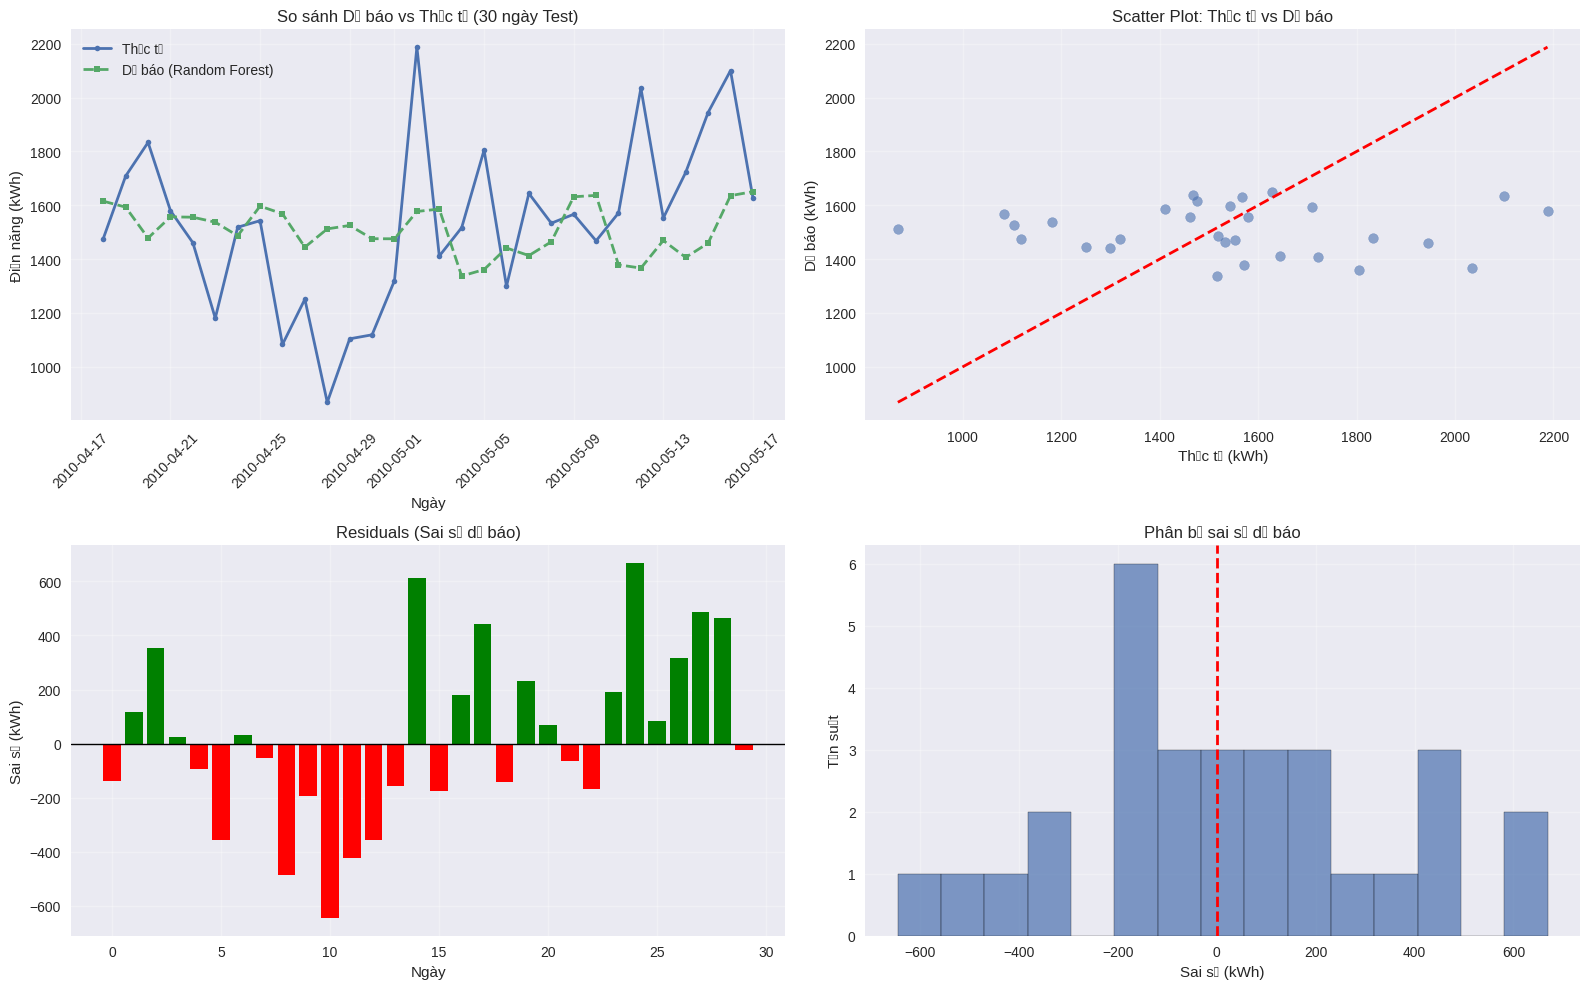

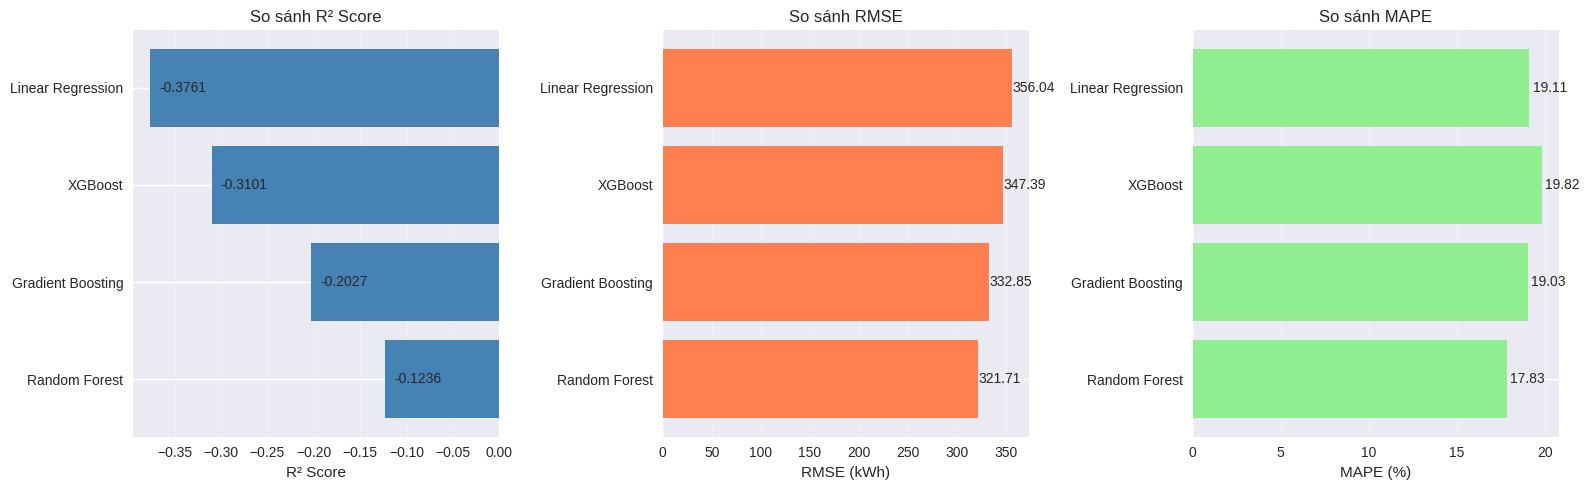


[Feature Importance] Random Forest


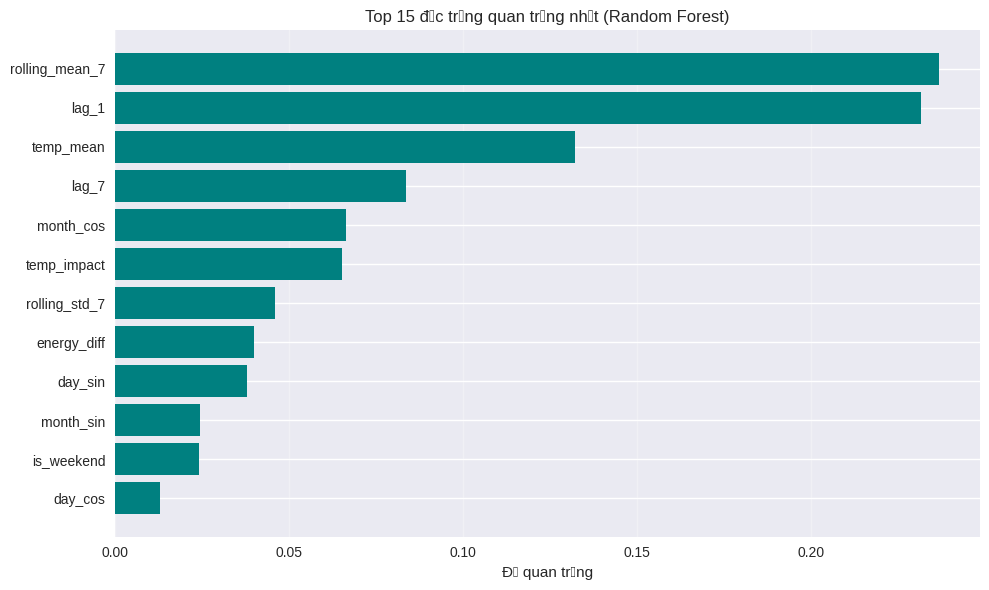

In [168]:
best_result = final_results[best_model_name]['Test']
best_model = final_results[best_model_name]['Model']

# Biểu đồ 1: So sánh Dự báo vs Thực tế
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1.1 Đường thời gian
axes[0, 0].plot(best_result['Actual'].index, best_result['Actual'].values,
               label='Thực tế', linewidth=2, marker='o', markersize=4)
axes[0, 0].plot(best_result['Actual'].index, best_result['Forecasts'],
               label=f'Dự báo ({best_model_name})', linewidth=2,
               marker='s', markersize=4, linestyle='--')
axes[0, 0].set_title('So sánh Dự báo vs Thực tế (30 ngày Test)')
axes[0, 0].set_xlabel('Ngày')
axes[0, 0].set_ylabel('Điện năng (kWh)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 1.2 Scatter plot
axes[0, 1].scatter(best_result['Actual'].values, best_result['Forecasts'], alpha=0.6)
min_val = min(best_result['Actual'].values.min(), best_result['Forecasts'].min())
max_val = max(best_result['Actual'].values.max(), best_result['Forecasts'].max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0, 1].set_title('Scatter Plot: Thực tế vs Dự báo')
axes[0, 1].set_xlabel('Thực tế (kWh)')
axes[0, 1].set_ylabel('Dự báo (kWh)')
axes[0, 1].grid(True, alpha=0.3)

# 1.3 Residuals (Sai số)
residuals = best_result['Actual'].values - best_result['Forecasts']
axes[1, 0].bar(range(len(residuals)), residuals, color=['red' if x < 0 else 'green' for x in residuals])
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_title('Residuals (Sai số dự báo)')
axes[1, 0].set_xlabel('Ngày')
axes[1, 0].set_ylabel('Sai số (kWh)')
axes[1, 0].grid(True, alpha=0.3)

# 1.4 Phân bổ residuals
axes[1, 1].hist(residuals, bins=15, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Phân bổ sai số dự báo')
axes[1, 1].set_xlabel('Sai số (kWh)')
axes[1, 1].set_ylabel('Tần suất')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Biểu đồ 2: So sánh hiệu suất các mô hình
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models = df_summary['Model'].values
r2_scores = df_summary['R2_Test'].values
rmse_scores = df_summary['RMSE_Test'].values
mape_scores = df_summary['MAPE_Test (%)'].values

# 2.1 R² Score
axes[0].barh(models, r2_scores, color='steelblue')
axes[0].set_xlabel('R² Score')
axes[0].set_title('So sánh R² Score')
axes[0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(r2_scores):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center')

# 2.2 RMSE
axes[1].barh(models, rmse_scores, color='coral')
axes[1].set_xlabel('RMSE (kWh)')
axes[1].set_title('So sánh RMSE')
axes[1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(rmse_scores):
    axes[1].text(v + 0.5, i, f'{v:.2f}', va='center')

# 2.3 MAPE
axes[2].barh(models, mape_scores, color='lightgreen')
axes[2].set_xlabel('MAPE (%)')
axes[2].set_title('So sánh MAPE')
axes[2].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(mape_scores):
    axes[2].text(v + 0.2, i, f'{v:.2f}', va='center')

plt.tight_layout()
plt.show()

# Biểu đồ 3: Feature Importance (nếu là tree-based model)
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    print(f"\n[Feature Importance] {best_model_name}")

    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        feature_names = selected_features

        # Sắp xếp theo độ quan trọng
        indices = np.argsort(importances)[::-1][:15]  # Top 15

        plt.figure(figsize=(10, 6))
        plt.barh(range(len(indices)), importances[indices], color='teal')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Độ quan trọng')
        plt.title(f'Top 15 đặc trưng quan trọng nhất ({best_model_name})')
        plt.gca().invert_yaxis()
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()


## **9. KẾT LUẬN VÀ KHUYẾN NGHỊ**

---



In [169]:
print(f"""
 TÓM TẮT KẾT QUẢ:
--------------------------------------------------
Mô hình tốt nhất: {best_model_name}
- R² Score: {df_summary.iloc[0]['R2_Test']:.4f} (Giải thích {df_summary.iloc[0]['R2_Test']*100:.2f}% phương sai)
- RMSE: {df_summary.iloc[0]['RMSE_Test']:.2f} kWh/ngày
- MAE: {df_summary.iloc[0]['MAE_Test']:.2f} kWh/ngày
- MAPE: {df_summary.iloc[0]['MAPE_Test (%)']:.2f}%
- Sai số tổng hóa đơn: {df_summary.iloc[0]['Total_Err_Test (%)']:.2f}%

 PHÂN TÍCH:
--------------------------------------------------
1. Độ chính xác:
   - Sai số trung bình mỗi ngày: ±{df_summary.iloc[0]['MAE_Test']:.2f} kWh
   - Tỷ lệ sai lệch: {df_summary.iloc[0]['MAPE_Test (%)']:.2f}%
   - Với hóa đơn 30 ngày, sai số dự kiến: {df_summary.iloc[0]['Total_Err_Test (%)']:.2f}%

2. Đặc trưng quan trọng:
   - Các lag features (lag_1, lag_7) có ảnh hưởng lớn
   - Đặc trưng rolling window giúp bắt xu hướng
   - Nhiệt độ và ngày lễ có tác động đáng kể

3. So sánh các mô hình:
   - {best_model_name} vượt trội về khả năng dự báo
   - Linear models phù hợp nếu cần tốc độ cao
   - Tree-based models bắt được phi tuyến tính tốt hơn

 HẠN CHẾ:
--------------------------------------------------
1. Dữ liệu nhiệt độ chỉ là proxy (ước lượng theo tháng)
2. Không có thông tin về giá điện theo giờ
3. Recursive forecasting tích lũy sai số theo thời gian
4. Chưa xét các sự kiện đặc biệt (dịch bệnh, khủng hoảng năng lượng)

 HƯỚNG CẢI TIẾN:
--------------------------------------------------
1. Thu thập dữ liệu thời tiết thực tế (API)
2. Thêm dữ liệu giá điện theo khung giờ
3. Sử dụng mô hình LSTM/Prophet cho chuỗi thời gian
4. Kết hợp ensemble của nhiều mô hình
5. Thêm dữ liệu về các sự kiện lớn (COVID-19, lễ hội)
6. Áp dụng cross-validation chuỗi thời gian (Time Series CV)

 ỨNG DỤNG THỰC TẾ:
--------------------------------------------------
- Tối ưu hóa mua điện cho doanh nghiệp
- Dự báo nhu cầu năng lượng cho grid management
- Phát hiện bất thường trong tiêu thụ điện
- Lập kế hoạch bảo trì thiết bị điện
""")

print("\n" + "="*80)
print(" HOÀN TẤT TOÀN BỘ QUY TRÌNH DỰ BÁO")
print("="*80)


 TÓM TẮT KẾT QUẢ:
--------------------------------------------------
Mô hình tốt nhất: Random Forest
- R² Score: -0.1236 (Giải thích -12.36% phương sai)
- RMSE: 321.71 kWh/ngày
- MAE: 258.21 kWh/ngày
- MAPE: 17.83%
- Sai số tổng hóa đơn: 1.73%

 PHÂN TÍCH:
--------------------------------------------------
1. Độ chính xác:
   - Sai số trung bình mỗi ngày: ±258.21 kWh
   - Tỷ lệ sai lệch: 17.83%
   - Với hóa đơn 30 ngày, sai số dự kiến: 1.73%

2. Đặc trưng quan trọng:
   - Các lag features (lag_1, lag_7) có ảnh hưởng lớn
   - Đặc trưng rolling window giúp bắt xu hướng
   - Nhiệt độ và ngày lễ có tác động đáng kể

3. So sánh các mô hình:
   - Random Forest vượt trội về khả năng dự báo
   - Linear models phù hợp nếu cần tốc độ cao
   - Tree-based models bắt được phi tuyến tính tốt hơn

 HẠN CHẾ:
--------------------------------------------------
1. Dữ liệu nhiệt độ chỉ là proxy (ước lượng theo tháng)
2. Không có thông tin về giá điện theo giờ
3. Recursive forecasting tích lũy sai số theo